In [36]:
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from nltk.corpus import stopwords
from collections import Counter 
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, SQLTransformer,IndexToString
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from unidecode import unidecode
from pyspark.sql.functions import regexp_replace, col, substring, udf
import pyspark.sql.functions as F
import pandas as pd
#from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [37]:
spark = SparkSession.builder \
        .appName("Spark NLP") \
        .master("local[4]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.driver.maxResultSize", "0") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.0") \
        .getOrCreate()

In [39]:
add_stop_words = ['ok', 'know', 'im', 'dont', 'need', 'late', 'da', 'ill', 'hi', 'want', 'didnt', 'ive', 'let', 'x']
stop_words = stopwords.words('english') + list(STOP_WORDS) + add_stop_words

# Read Dataset

In [40]:
%%time
# File location and type
file_location = r'dataset/SPAM.csv'
file_type = "csv"# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
df = spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header).option("sep", delimiter).load(file_location)
# Registers count
df.count()

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 196 ms


5574

# Basic metrics

In [41]:
%%time
# Check if there are null values
df.filter(df.Message.isNull()).show()

+--------+-------+
|Category|Message|
+--------+-------+
+--------+-------+

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 64 ms


In [42]:
# Count register per category
df.groupBy(["Category"]).count().show()

+--------+-----+
|Category|count|
+--------+-----+
|     ham| 4827|
|    spam|  747|
+--------+-----+



# Create pipelines for apply text mining techniques

In [44]:
# Assembler
documentAssembler = DocumentAssembler() \
     .setInputCol('Message') \
     .setOutputCol('document_text')

# Tokenizer
tokenizer = Tokenizer() \
     .setInputCols(['document_text']) \
     .setOutputCol('token')

# Cleaner
normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True) 

# Lemmatizer
lemmatizer = LemmatizerModel.pretrained(lang="en") \
     .setInputCols('normalized') \
     .setOutputCol('lemma')

# Stopwords
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols('lemma') \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(stop_words)

# Ngrams
ngrams_nonCum = NGramGenerator() \
            .setInputCols(["clean_lemma"]) \
            .setOutputCol("ngrams") \
            .setN(3) \
            .setEnableCumulative(False)\
            #.setDelimiter("_") # Default is space

# Concat 
tokenassembler = TokenAssembler()\
    .setInputCols(["document_text", "clean_lemma"]) \
    .setOutputCol("clean_text") \
    .setPreservePosition(False)

# Finisher
finisher = Finisher() \
    .setInputCols(["clean_lemma"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)# To generate Term Frequency

# To generate Inverse Document Frequency
hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=1000)

# convert labels (string) to integers. Easy to process compared to string
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=10)

label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")

# To convert index(integer) to corresponding class labels
lr = GBTClassifier(maxIter=100)

# Define nlp pipeline
label_to_stringIdx = IndexToString(inputCol="label", outputCol="article_class")

nlp_pipeline = Pipeline(
    stages=[
            documentAssembler,
            tokenizer,
            normalizer,
            lemmatizer,
            stopwords_cleaner,
            ngrams_nonCum,
           tokenassembler,
           finisher,
           hashingTF,
           idf,
           label_stringIdx,
           lr,
           label_to_stringIdx
           ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [45]:
# Train and Test
train, test = df.randomSplit([0.7, 0.3])

In [46]:
%%time
# Apply pipeline
df_pipeline = nlp_pipeline.fit(train).transform(test)

CPU times: user 109 ms, sys: 62.5 ms, total: 172 ms
Wall time: 37.4 s


In [47]:
# Visualize an example with a text transformed
df_pipeline.select(['Message']).take(1)

[Row(Message=' Yeah')]

In [48]:
# Visualize an example with an original text
df_pipeline.select(['clean_text.result']).take(1)

[Row(result=['yeah'])]

# Create a view in spark to get results and manipulate

In [49]:
# Create a temporary view
df_pipeline.createOrReplaceTempView("SPAM")

In [50]:
%%time
# Test select
txt = spark.sql('SELECT count(*) as qtd FROM SPAM')
txt.show()

+----+
| qtd|
+----+
|1630|
+----+

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 98.7 ms


# Visualize wordcloud for each category

In [51]:
# Function to apply wordcloud
def word_cloud(posts):
    text = " ".join(review for review in posts)
    wc = WordCloud(max_font_size=500,width = 3000, height = 1000, background_color="white").generate(text)
    # plot the WordCloud image  
    plt.figure(figsize = (10,10)) 
    plt.imshow(wc, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show()

In [52]:
%%time
# Get words results of pipelines and put in pandas dataframe
words = spark.sql('SELECT clean_text.result, category FROM SPAM')
words_df = words.toPandas()

CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 744 ms


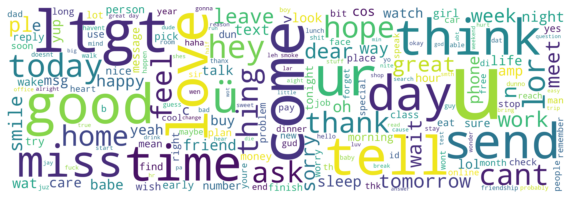

CPU times: user 4.92 s, sys: 188 ms, total: 5.11 s
Wall time: 5.11 s


In [53]:
%%time
# Ham
word_cloud([sent for txt in words_df[words_df['category'] == 'ham']['result'] for sent in txt])

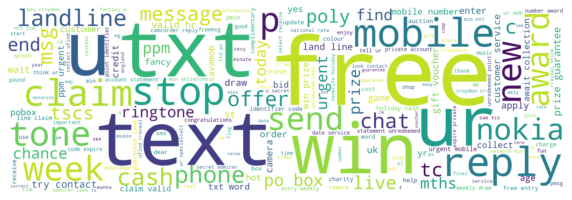

CPU times: user 5.14 s, sys: 141 ms, total: 5.28 s
Wall time: 5.27 s


In [54]:
%%time
# Spam
word_cloud([sent for txt in words_df[words_df['category'] == 'spam']['result'] for sent in txt])

# Visualize 3-GRAMS

In [55]:
%%time
# Select ngrams from pipelines
ngram = spark.sql('SELECT ngrams.result, category from SPAM')
ngram_df = ngram.toPandas()

CPU times: user 62.5 ms, sys: 31.2 ms, total: 93.8 ms
Wall time: 920 ms


In [56]:
%%time
# Transform it in a dict
ngram_count_ham = dict(Counter([word for arr in ngram_df[ngram_df['category'] == 'ham']['result'] for word in arr]))
ngram_count_spam = dict(Counter([word for arr in ngram_df[ngram_df['category'] == 'spam']['result'] for word in arr]))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.14 ms


In [57]:
%%time
ngramcount = {}
ngramcount['ham'] = ngram_count_ham
ngramcount['spam'] = ngram_count_spam

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 88.7 µs


In [58]:
%%time
data_ngram = {}
data_ngram['ham'] ={}
data_ngram['ham']['ngram'] = []
data_ngram['ham']['Count'] = []
data_ngram['spam'] = {}
data_ngram['spam']['ngram'] = []
data_ngram['spam']['Count'] = []

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 82 µs


In [59]:
%%time
for i in ngramcount:
    for k,v in ngramcount[i].items():
        data_ngram[i]['ngram'].append(k)
        data_ngram[i]['Count'].append(v)
        
df_ham = pd.DataFrame(data_ngram['ham'])
df_ham['ham'] = "ham"
df_spam = pd.DataFrame(data_ngram['spam'])
df_spam['spam'] = "spam"
df_ngram = pd.concat([df_ham, df_spam])

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 13 ms


CPU times: user 266 ms, sys: 62.5 ms, total: 328 ms
Wall time: 168 ms


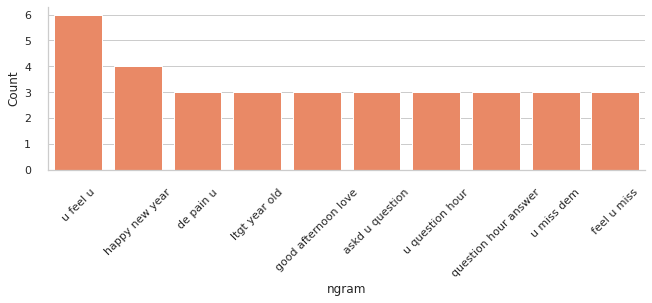

In [60]:
%%time
# Ham
sns.set(style="whitegrid")
ax = sns.catplot(x="ngram", y="Count", data=df_ngram[df_ngram['ham'] == "ham"].sort_values(by='Count', ascending=False).head(10), kind = 'bar', color ='coral', orient = 'v', height=3, aspect=3)
ax.set_xticklabels(rotation = 45)

CPU times: user 203 ms, sys: 93.8 ms, total: 297 ms
Wall time: 138 ms


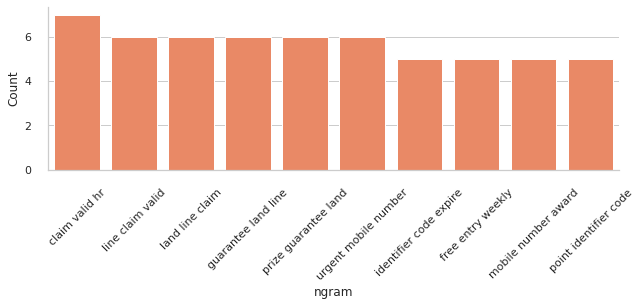

In [61]:
%%time
# Spam
sns.set(style="whitegrid")
ax = sns.catplot(x="ngram", y="Count", data=df_ngram[df_ngram['spam'] == "spam"].sort_values(by='Count', ascending=False).head(10), kind = 'bar', color ='coral', orient = 'v', height=3, aspect=3)
ax.set_xticklabels(rotation = 45)

## Check xgboost classifier results

In [62]:
%%time
# Check accuracy
evaluator_acc =MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_acc = evaluator_acc.evaluate(df_pipeline)
print("Accuracy = %g" % (accuracy_acc))
print("Test Error = %g " % (1.0 - accuracy_acc))

Accuracy = 0.963804
Test Error = 0.0361963 
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 768 ms


In [63]:
%%time
# Check precision
evaluator_p = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision_p = evaluator_p.evaluate(df_pipeline)
print("Precision = %g" % (precision_p))
print("Test Error = %g " % (1.0 - precision_p))

Precision = 0.962941
Test Error = 0.0370591 
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 718 ms


In [64]:
# Confusion matrix
y_true = df_pipeline.select("label")
y_true = y_true.toPandas()

y_pred = df_pipeline.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)

In [65]:
confusion_matrix = pd.DataFrame(cnf_matrix, columns = ['ham', 'spam'])
confusion_matrix['Predictors'] = ['ham', 'spam']
confusion_matrix.set_index('Predictors')

,ham,spam
Predictors,,
ham,1392,16
spam,43,179
